In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

#KNN分类器
class KNNClassifier():
    
    
    #初始化分类器
        #:param k: positive integer K最近邻法中K的取值
        #:param dist: "Euclidean" or "Mahalanobis"
    def __init__(self, k, dist="Euclidean", mat_dim=2):

        if isinstance(k, int) and k > 0:
            self.k = k
        else:
            raise ValueError("k必须是正整数，现在k是{}，类型为{}".format(k, type(k))) #对初始化K提出修改要求

        if dist == "Euclidean" or dist == "Mahalanobis" or dist == "Chebyshev" or dist == "Manhattan" :
            self.dist = dist
        else:
            raise ValueError("距离度量不在本题的使用范围内") #对初始化distance提出修改要求

        if dist == "Mahalanobis":
            self.mat_dim = mat_dim

  
    # 出于数值精度考虑，需要先归一化，从数学上没有影响，但需要在所有位置都归一化
        #:param train_data: ndarray of n_train x d
        #:return normalized: max-min normalized data
    def data_normalize(self, train_data):

        normalized = np.empty_like(train_data)

        self.min_vals = train_data.min(axis=0)  # 保存为类变量，方便test time调用
        self.max_vals = train_data.max(axis=0)

        for j in range(train_data.shape[1]):
            span = self.max_vals[j] - self.min_vals[j]
            for i in range(train_data.shape[0]):
                normalized[i, j] = (train_data[i, j] - self.min_vals[j]) / span
        
        return normalized  
                
        
    # 马氏距离
        #:param a: array
        #:param b: array of the same size
        #:return Mahalanobis distance between a and b
    def __dist_Mahalanobis(self, a, b):
        
        if len(a) != len(b):
            raise ValueError("两向量维度不一致")
#         if len(a) != self.A.shape[1]:
#             raise ValueError("马氏距离没有基于数据学习")

        n_features = len(a)
        a = a.reshape((n_features, 1))
        b = b.reshape((n_features, 1))

        dist_mah = np.sqrt((a - b).T @ self.A.T @ self.A @ (a - b))
        return dist_mah
    
    def __calculate_pro(self, train_data):
        n_data = train_data.shape[0]
        self.pro = np.zeros((n_data, n_data))  # 用一个矩阵存所有的p_ij

        for i in range(n_data):
            x_i = train_data[i]
            denominator = 0

            for j in range(n_data):
                if j != i:
                    x_j = train_data[j]
                    self.pro[i, j] = np.exp(-np.power(self.__dist_Mahalanobis(x_i, x_j),2))
                    denominator += self.pro[i, j]

            self.pro[i, :] /= denominator
    
     # 马氏距离的学习的目标函数
        #:param train_data: ndarray of n_train x d
        #:param train_label: ndarray of n_train x 1
        #:return: output of the objective function
    def __objective(self, train_data, train_label):
        
        total = 0
        for i in range(train_data.shape[0]):
            label = train_label[i]  # 得到一行数据对应的label
            index_of_this_class = np.argwhere(train_label == label)[:, 0]  # 得到同类的所有样本的索引

            for j in index_of_this_class:
                if j != i:
                    total += self.pro[i, j] # f(A)= \sum \sum p_ij

        return total


    # 学习马氏距离度量
        #:param train_data: ndarray of n_train x d
        #:param train_label: ndarray of n_train x 1
        #:param lr: learning rate, float
        #:param n_iter: number of iterations to conduct, int
        #:param early_stop: stop according to criterion, bool
        #:return loss_list
    def fit(self, train_data, train_label, lr, n_iter, early_stop=True):

        if self.dist == "euclidean" or self.dist == "Chebyshev" or self.dist == "Manhattan":
            print("欧式距离、切比雪夫距离、曼哈顿距离不能被学习")
            return

        train_data = self.data_normalize(train_data)  # 归一化

        n_features = train_data.shape[1] #shape[1]为数据的列数
        self.A = np.random.rand(self.mat_dim, n_features)  # 随机初始化A矩阵
        self.__calculate_pro(train_data)  # 计算P矩阵
        loss_list = [self.__objective(train_data, train_label)]

        print("开始训练……")
        print("objective:", loss_list[0])

        # 计算梯度
        for current_iter in range(1, n_iter + 1):
            # print(f"Epoch {current_iter} starts")

            temp = np.zeros((n_features, n_features))
            for i in range(train_data.shape[0]):
                x_i = train_data[i]
                label = train_label[i]  # 得到一行数据对应的label
                index_of_this_class = np.argwhere(train_label == label)[:, 0]  # 得到同类的所有样本的索引

                for j in index_of_this_class:
                    if j != i:
                        subtemp = np.zeros((n_features, n_features))
                        for k in range(train_data.shape[0]):
                            if k != i:
                                x_k = train_data[k]
                                x_ik = (x_i - x_k).reshape((n_features, 1))
                                subtemp += self.pro[i, k] * (x_ik @ x_ik.T) # \sum p_ij@(x_i-x_k)^T@(x_i-x_k)

                        x_j = train_data[j]
                        x_ij = (x_i - x_j).reshape((n_features, 1))
                        temp += self.pro[i, j] * ((x_ij @ x_ij.T) - subtemp)

            grad = - 2 * self.A @ temp
            print("Epoch {}/{} \t Gradient = {}".format(current_iter, n_iter, grad))
            self.A += lr * grad  # 梯度上升
            self.__calculate_pro(train_data)  # 更新P矩阵
            loss_list.append(self.__objective(train_data, train_label))
            print(f"Epoch {current_iter}/{n_iter}\t objective: {loss_list[-1]}")

            # 提前中止
            if early_stop and current_iter > 5:
                if abs(loss_list[-1] - loss_list[-2]) < 0.03: #threshold设置
                    break

        return loss_list
    

    #To do: How to 更高效地计算p_ij，每次更新A后都必须重新计算！
    


                
    
    # 预测单个样本
        #:param train_data: nd-array of n_train x d
        #:param train_label: nd-array of n_train x 1
        #:param test_ins: 矩阵维度 d-dimensional array 
        #:return test_label: integer
    def predict(self, train_data, train_label, test_ins):

#         train_data = self.data_normalize(train_data) #训练样本归一化
#         test_ins = (test_ins - self.min_vals) / (self.max_vals - self.min_vals)  # 测试样本初始化

        if self.dist == "Euclidean":
            distances = np.linalg.norm(train_data - test_ins, axis=1)  #欧氏距离赋值，ord=None 默认为L2-norm；axis=1表示按行向量处理，求多个行向量的范数；
        
        if self.dist == "Chebyshev":
            distances = np.linalg.norm(train_data - test_ins, ord = np.inf, axis=1)
        
        if self.dist == "Manhattan":
            distances = np.linalg.norm(train_data - test_ins, ord = 1, axis=1)
        
        if self.dist == "Mahalanobis":
            distances = np.empty(train_data.shape[0])  #马氏距离初始化
            for i in range(len(distances)):
                distances[i] = self.__dist_Mahalanobis(test_ins, train_data[i]) #马氏距离赋值

        train_label = train_label.flatten()
        k_neighbor_index = np.argsort(distances)[:self.k]
        neighbor_labels = train_label[k_neighbor_index]
        most_voted = np.argmax(np.bincount(neighbor_labels))
#         print("在k={}下，邻居点的标签为{}，最后判定的结果应当为{}".format(self.k, neighbor_labels, most_voted))

        return most_voted

In [2]:
k_values = range(1,41,2)
#测试欧式距离 trian vs valid
def test_Euclidean(train, valid):
    
    train_frames = [train['R'],train['F'],train['M'],train['T']]
    X_train = np.array(pd.concat(train_frames, axis = 1))
    Y_train = np.array(train['label'])
    
    valid_frames = [valid['R'],valid['F'],valid['M'],valid['T']]
    X_valid =  np.array(pd.concat(valid_frames, axis = 1))
    Y_valid =  np.array(valid['label'])
    
    cls = KNNClassifier(1)
    acc_list = []
    for k in k_values:
        cls.k = k
        true_cnt, total_cnt = 0, 0
        for i in range(X_valid.shape[0]):
            sample = X_valid[i]
            pred = cls.predict(X_train, Y_train, sample)#对X_valid进行预测
            truth = Y_valid[i]
            if pred == int(truth):
                true_cnt += 1
            total_cnt += 1

        acc_list.append(true_cnt / total_cnt)

    print("Euclidean distance:", acc_list)

    return cls, acc_list

#测试切比雪夫距离 trian vs valid
def test_Chebyshev(train, valid):
    
    train_frames = [train['R'],train['F'],train['M'],train['T']]
    X_train = np.array(pd.concat(train_frames, axis = 1))
    Y_train = np.array(train['label'])
    
    valid_frames = [valid['R'],valid['F'],valid['M'],valid['T']]
    X_valid =  np.array(pd.concat(valid_frames, axis = 1))
    Y_valid =  np.array(valid['label'])
    
    cls = KNNClassifier(1,dist="Chebyshev")
    acc_list = []
    for k in  k_values:
        cls.k = k
        true_cnt, total_cnt = 0, 0
        for i in range(X_valid.shape[0]):
            sample = X_valid[i]
            pred = cls.predict(X_train, Y_train, sample)
            truth = Y_valid[i]
            if pred == int(truth):
                true_cnt += 1
            total_cnt += 1

        acc_list.append(true_cnt / total_cnt)

    print("Chebyshev distance:", acc_list)

    return cls, acc_list

#测试曼哈顿距离 trian vs valid
def test_Manhattan(train, valid):
    
    train_frames = [train['R'],train['F'],train['M'],train['T']]
    X_train = np.array(pd.concat(train_frames, axis = 1))
    Y_train = np.array(train['label'])
    
    valid_frames = [valid['R'],valid['F'],valid['M'],valid['T']]
    X_valid =  np.array(pd.concat(valid_frames, axis = 1))
    Y_valid =  np.array(valid['label'])
    
    cls = KNNClassifier(1,dist="Manhattan")
    acc_list = []
    for k in  k_values:
        cls.k = k
        true_cnt, total_cnt = 0, 0
        for i in range(X_valid.shape[0]):
            sample = X_valid[i]
            pred = cls.predict(X_train, Y_train, sample)
            truth = Y_valid[i]
            if pred == int(truth):
                true_cnt += 1
            total_cnt += 1

        acc_list.append(true_cnt / total_cnt)
        
    print("Manhattan distance:", acc_list)

    return cls, acc_list

#测试马氏距离 trian vs valid
def test_Mahalanobis(train, valid):
    
    train_frames = [train['R'],train['F'],train['M'],train['T']]
    X_train = np.array(pd.concat(train_frames, axis = 1))
    Y_train = np.array(train['label'])
    
    valid_frames = [valid['R'],valid['F'],valid['M'],valid['T']]
    X_valid =  np.array(pd.concat(valid_frames, axis = 1))
    Y_valid =  np.array(valid['label'])
    
    acc_list = []
    cls = KNNClassifier(1, dist="Mahalanobis", mat_dim=2)
    loss = cls.fit(X_train, Y_train, lr=0.3, n_iter=20) #学习马氏距离，参数还有待调整

    for k in k_values:
        cls.k = k
        true_cnt, total_cnt = 0, 0
        for i in range(X_valid.shape[0]):
            sample = X_valid[i]
            pred = cls.predict(X_train, Y_train, sample)
            truth = Y_valid[i]
            if pred == int(truth):
                true_cnt += 1
            total_cnt += 1

        acc_list.append(true_cnt / total_cnt)

    print("Mahalanobis distance:", acc_list)

    return cls, acc_list



Euclidean distance: [0.9324324324324325, 0.8108108108108109, 0.7972972972972973, 0.7837837837837838, 0.7567567567567568, 0.7837837837837838, 0.7972972972972973, 0.7702702702702703, 0.7567567567567568, 0.7567567567567568, 0.7567567567567568, 0.7162162162162162, 0.7027027027027027, 0.7162162162162162, 0.6891891891891891, 0.6891891891891891, 0.6891891891891891, 0.6891891891891891, 0.6891891891891891, 0.6891891891891891]
Euclidean下 次优的k值：3
Chebyshev distance: [0.8783783783783784, 0.7837837837837838, 0.7972972972972973, 0.7297297297297297, 0.7567567567567568, 0.7702702702702703, 0.7702702702702703, 0.7702702702702703, 0.7567567567567568, 0.7162162162162162, 0.7567567567567568, 0.7162162162162162, 0.7162162162162162, 0.7162162162162162, 0.6891891891891891, 0.6891891891891891, 0.6891891891891891, 0.6891891891891891, 0.6891891891891891, 0.6891891891891891]
Chebyshev下 次优的k值：5
Manhattan distance: [0.9459459459459459, 0.8108108108108109, 0.8108108108108109, 0.7702702702702703, 0.7702702702702703,

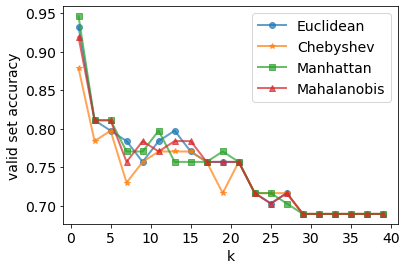

In [3]:
# k_values = range(1,21)
import pickle #仅用于保存模型，对题目没有帮助

def main():
    # 读取数据
    train = pd.read_csv("./train_data.csv", header = 0, names = ['R','F','M','T','label'])
    valid = pd.read_csv("./val_data.csv", header = 0, names = ['R','F','M','T','label'])
    test = pd.read_csv("./test_data.csv", header = 0, names = ['R','F','M','T'])
    
    #转变数据类型，提升速度
    train_frames = [train['R'],train['F'],train['M'],train['T']]
    X_train = np.array(pd.concat(train_frames, axis = 1))
    Y_train = np.array(train['label'])
    
    valid_frames = [valid['R'],valid['F'],valid['M'],valid['T']]
    X_valid =  np.array(pd.concat(valid_frames, axis = 1))
    Y_valid =  np.array(valid['label'])
    
    test_frames = [test['R'],test['F'],test['M'],test['T']]
    X_test =  np.array(pd.concat(test_frames, axis = 1))
    
    
    k_value_array = np.array(k_values)
    k_value_list = k_value_array.tolist()
    
    #以Euclidean距离为度量的模型
    cls_euc, euc_acc_list = test_Euclidean(train, valid)
    k_value_pair_euc = list(zip(k_value_list,euc_acc_list))
    cls_euc.k = sorted(k_value_pair_euc, key = lambda x:x[1], reverse = True)[1][0]
#     print(k_value_pair_euc)
    print("Euclidean下 次优的k值：{}".format(cls_euc.k))
    pickle.dump(cls_euc,open("KNNClassifier_Euclidean.dat","wb")) #保存模型
#     cls_euc_1 = pickle.load("KNNClassifier_Euclidean.dat")
    
    #以Chebyshev距离为度量的模型
    cls_che, che_acc_list = test_Chebyshev(train, valid)
    k_value_pair_che = list(zip(k_value_list,che_acc_list))
    cls_che.k = sorted(k_value_pair_che, key = lambda x:x[1], reverse = True)[1][0]
#     print(k_value_pair_che)
    print("Chebyshev下 次优的k值：{}".format(cls_che.k))
    pickle.dump(cls_che,open("KNNClassifier_Chebyshev.dat","wb")) #保存模型
#     print(sorted(k_value_pair_che, key = lambda x:x[1], reverse = True))
    
    #以Manhattan距离为度量的模型
    cls_man, man_acc_list = test_Manhattan(train, valid)
    k_value_pair_man = list(zip(k_value_list,man_acc_list))
    cls_man.k = sorted(k_value_pair_man, key = lambda x:x[1], reverse = True)[1][0]
#     print(k_value_pair_man)
    print("Manhattan下 次优的k值：{}".format(cls_man.k))
    pickle.dump(cls_man,open("KNNClassifier_Manhattan.dat","wb")) #保存模型
    
    
    #使用Euclidean距离预测test数据
    with open('temp11.csv','w',encoding = 'utf-8') as f:
        f.write("My prediction\n")
        for i in range(X_test.shape[0]):
            test_ins = X_test[i]
            pred = cls_euc.predict(X_train, Y_train, test_ins)
            f.write("{:d}\n".format(pred))

    predict_data_11 = pd.read_csv('temp11.csv')
    test_data = pd.read_csv('test_data.csv')
    test_data['My prediction'] = predict_data_11
    test_data.to_csv('task11_test_prediction.csv', mode = 'a', index =False)
    
    #使用Chebyshev距离预测test数据
    with open('temp12.csv','w',encoding = 'utf-8') as f:
        f.write("My prediction\n")
        for i in range(X_test.shape[0]):
            test_ins = X_test[i]
            pred = cls_che.predict(X_train, Y_train, test_ins)
            f.write("{:d}\n".format(pred))
    predict_data_12 = pd.read_csv('temp12.csv')
    test_data = pd.read_csv('test_data.csv')
    test_data['My prediction'] = predict_data_12
    test_data.to_csv('task12_test_prediction.csv', mode = 'a', index =False)       
            
    #使用Manhattan距离预测test数据
    with open('temp13.csv','w',encoding = 'utf-8') as f:
        f.write("My prediction\n")
        for i in range(X_test.shape[0]):
            test_ins = X_test[i]
            pred = cls_man.predict(X_train, Y_train, test_ins)
            f.write("{:d}\n".format(pred))
    predict_data_13 = pd.read_csv('temp13.csv')
    test_data = pd.read_csv('test_data.csv')
    test_data['My prediction'] = predict_data_13
    test_data.to_csv('task13_test_prediction.csv', mode = 'a', index =False)



    #以马氏距离为度量的模型
    cls_mah, mah_acc_list = test_Mahalanobis(train, valid)
    k_value_pair_mah = list(zip(k_value_list,mah_acc_list))
    cls_mah.k = sorted(k_value_pair_mah, key = lambda x:x[1], reverse = True)[1][0]
    print("Mahalanobis下 次优的k值：{}".format(cls_mah.k))

    #保存模型
    with open('./KNNClassifier_Mahalanobis.dat','wb') as f:
        pickle.dump(cls_mah, f)
#     #调取模型
#     with open('./KNNClassifier_Mahalanobis.dat','rb') as f:
#         cls_mah_1 = pickle.load(f)

    #存储数据
     with open('temp2.csv', 'w', encoding='utf-8') as f:
        f.write("My prediction\n")
        for i in range(X_test.shape[0]):
            test_ins = X_test[i]
            pred = cls_mah.predict(X_train, Y_train, test_ins)
            f.write("{:d}\n".format(pred))    
        
    predict_data_2 = pd.read_csv('temp2.csv')
    test_data_2 = pd.read_csv('test_data.csv')
    test_data_2['My prediction'] = predict_data_1
    test_data_2.to_csv('task2_test_prediction.csv', mode = 'a', index =False)
        

    #绘制图像        
    plt.figure()
    plt.plot(k_values, euc_acc_list, linewidth='2', marker='o',alpha = 0.7, label='Euclidean')
    plt.plot(k_values, che_acc_list, linewidth='2', marker='*',alpha = 0.7, label='Chebyshev')
    plt.plot(k_values, man_acc_list, linewidth='2', marker='s',alpha = 0.7, label='Manhattan')
    plt.plot(k_values, mah_acc_list, linewidth='2', marker='^',alpha = 0.7, label='Mahalanobis')
    plt.xlabel("k", fontsize=14)
    plt.ylabel("valid set accuracy", fontsize=14)
    plt.xticks([0, 5, 10, 15, 20, 25, 30, 35, 40], fontsize=14)
    plt.yticks(fontsize=14)
    plt.legend(fontsize=14)
    plt.show()


if __name__ == "__main__":
    main()